# Train Models With Weights


## Load The Dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mariaherrerot/aptos2019")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'aptos2019' dataset.
Path to dataset files: /kaggle/input/aptos2019


## First Model

In [ ]:
unbalanced_data_path = path+'/train_images/train_images'

In [ ]:
y_true = pd.read_csv(path+'/train_1.csv')
y_true['id_code'] = y_true['id_code'].map(lambda x: x + '.png' if not x.endswith('.png') else x)
y_true.head()

,id_code,diagnosis
0,1ae8c165fd53.png,2
1,1b329a127307.png,1
2,1b32e1d775ea.png,4
3,1b3647865779.png,0
4,1b398c0494d1.png,0


In [ ]:
y_true['diagnosis']=y_true['diagnosis'].astype(str)
y_true.head()

,id_code,diagnosis
0,1ae8c165fd53.png,2
1,1b329a127307.png,1
2,1b32e1d775ea.png,4
3,1b3647865779.png,0
4,1b398c0494d1.png,0


## Data Prep

In [ ]:
train_df, val_df = train_test_split(y_true,test_size=0.15,random_state=0,stratify=y_true['diagnosis'])
print("Train and validation dataframes regenerated.")

Train and validation dataframes regenerated.


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    horizontal_flip=True,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [ ]:
val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=unbalanced_data_path,
    x_col='id_code',
    y_col='diagnosis',
    target_size=(224,224),
    batch_size=32,
    class_mode='sparse',
    shuffle=True,
    seed=0
)

Found 2490 validated image filenames belonging to 5 classes.


In [ ]:
val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=unbalanced_data_path,
    x_col='id_code',
    y_col='diagnosis',
    target_size=(224,224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

Found 440 validated image filenames belonging to 5 classes.


In [ ]:
classes = np.unique(train_df['diagnosis'])
class_weights = compute_class_weight('balanced', classes=classes, y=train_df['diagnosis'].values)
class_weight_dict = {c: w for c, w in zip(classes, class_weights)}


print(class_weight_dict)

{'0': np.float64(0.4088669950738916), '1': np.float64(1.9529411764705882), '2': np.float64(0.7248908296943232), '3': np.float64(3.801526717557252), '4': np.float64(2.5025125628140703)}


## Load VGG16 Base Model



In [ ]:
from tensorflow.keras.applications import VGG16
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

for layer in base_model.layers:
    layer.trainable = False

print("EfficientNetB5 base model loaded and its layers frozen.")

EfficientNetB5 base model loaded and its layers frozen.


## Add Attention Mechanism




In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Reshape, Multiply

x = base_model.output

ap = GlobalAveragePooling2D()(x)

attention_probs = Dense(64, activation='relu')(ap)

attention_probs = Dense(512, activation='sigmoid')(attention_probs)

attention_probs = Reshape((1, 1, 512))(attention_probs)

attended_output = Multiply()([x, attention_probs])

## Add Classification Head



In [ ]:
x = GlobalAveragePooling2D()(attended_output)
x = Dense(256, activation='relu')(x)
output_layer = Dense(len(classes), activation='softmax')(x)

## Compile The Model



In [ ]:
model_checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint(filepath='vgg_best_with_weights.keras',monitor='val_sparse_categorical_accuracy',save_best_only=True)
early_stop_it=tensorflow.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy',patience=4,restore_best_weights=True,mode='max')

In [ ]:
model = Model(inputs=base_model.input, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=1e-4),loss=SparseCategoricalCrossentropy(from_logits=False),metrics=[tensorflow.keras.metrics.SparseCategoricalAccuracy()])

# Train The Model

In [ ]:
history=model.fit(train_gen,validation_data=val_gen,epochs=20,class_weight=class_weight_dict,callbacks=[model_checkpoint_callback,early_stop_it])

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 462s 6s/step - loss: 1.4515 - sparse_categorical_accuracy: 0.4141 - val_loss: 1.2451 - val_sparse_categorical_accuracy: 0.4909
Epoch 2/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 350s 4s/step - loss: 1.1987 - sparse_categorical_accuracy: 0.5026 - val_loss: 1.1649 - val_sparse_categorical_accuracy: 0.4909
Epoch 3/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 321s 4s/step - loss: 1.1273 - sparse_categorical_accuracy: 0.5979 - val_loss: 1.0856 - val_sparse_categorical_accuracy: 0.5591
Epoch 4/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 322s 4s/step - loss: 1.0659 - sparse_categorical_accuracy: 0.6479 - val_loss: 1.0104 - val_sparse_categorical_accuracy: 0.6545
Epoch 5/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 321s 4s/step - loss: 0.9547 - sparse_categorical_accuracy: 0.6987 - val_loss: 0.9524 - val_sparse_categorical_accuracy: 0.6545
Epoch 6/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 320s 4s/step - loss: 0.9220 - sparse_categorical_accuracy: 0.6857 - val_loss: 0.9282 - val_sparse_categorical_accuracy: 0.6591
Epoch 7/20

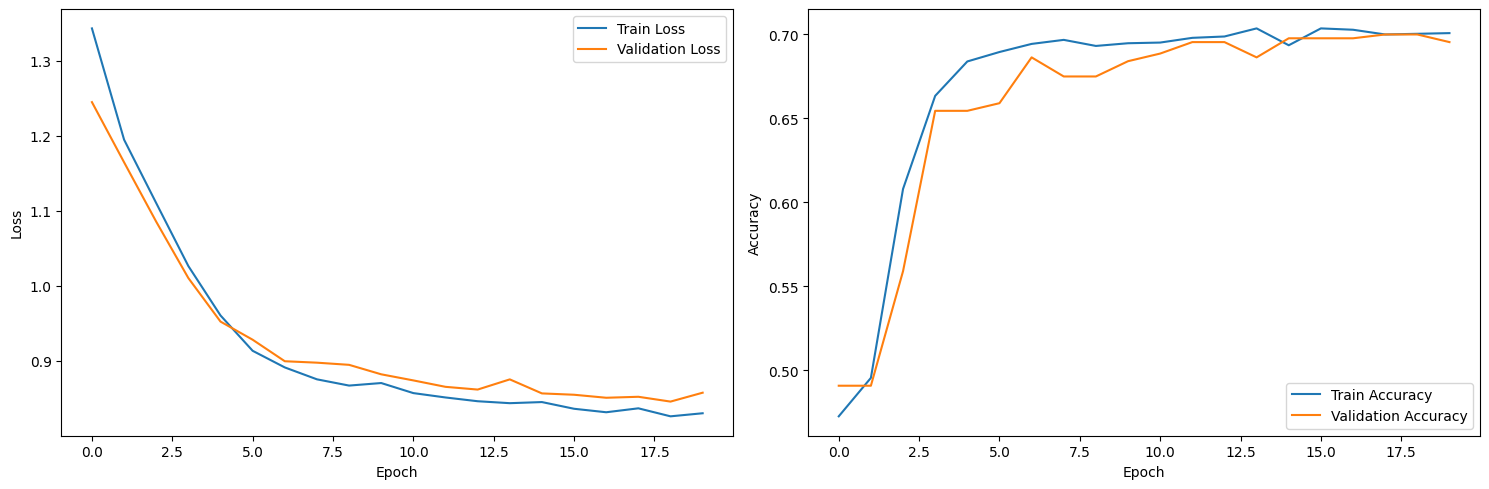

In [ ]:

ig,axes=plt.subplots(1,2,figsize=(15,5))

axes[0].plot(history.history['loss'],label='Train Loss')
axes[0].plot(history.history['val_loss'],label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(history.history['sparse_categorical_accuracy'],label='Train Accuracy')
axes[1].plot(history.history['val_sparse_categorical_accuracy'],label='Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()

## Prepare Sample Image For Attention maps



In [ ]:
images, labels = next(val_gen)
sample_image = images[0]
sample_label = labels[0]
sample_image_processed = np.expand_dims(sample_image, axis=0)

print(f"Sample image shape: {sample_image.shape}")
print(f"Sample image processed shape for model input: {sample_image_processed.shape}")
print(f"Sample label: {sample_label}")

Sample image shape: (224, 224, 3)
Sample image processed shape for model input: (1, 224, 224, 3)
Sample label: 2.0


## Generate Attention Heatmap


In [ ]:
from scipy.ndimage import zoom
attention_model = Model(inputs=base_model.input, outputs=[attention_probs, output_layer])


attention_map_raw, predictions = attention_model.predict(sample_image_processed)

attention_output_model = Model(inputs=base_model.input, outputs=attended_output)
attended_feature_map = attention_output_model.predict(sample_image_processed)

attention_map = np.mean(attended_feature_map, axis=-1)
attention_map = attention_map[0]


scale_factor_h = sample_image.shape[0] / attention_map.shape[0]
scale_factor_w = sample_image.shape[1] / attention_map.shape[1]

attention_map_resized = zoom(attention_map, (scale_factor_h, scale_factor_w), order=1)

print(f"Raw attention map shape: {attention_map.shape}")
print(f"Resized attention map shape: {attention_map_resized.shape}")
print(f"Model prediction for sample image: {predictions}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step
Raw attention map shape: (7, 7)
Resized attention map shape: (224, 224)
Model prediction for sample image: [[0.11385687 0.1106565  0.5302814  0.0887832  0.15642199]]


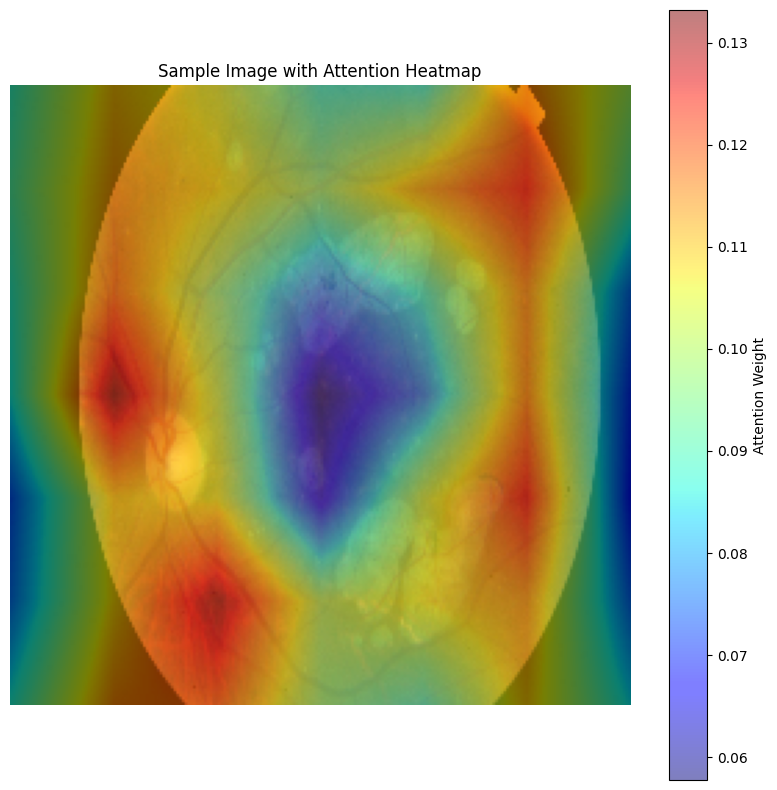

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 10))
plt.imshow(sample_image)
plt.imshow(attention_map_resized, cmap='jet', alpha=0.5)
plt.title('Sample Image with Attention Heatmap')
plt.axis('off')
plt.colorbar(label='Attention Weight')
plt.show()

# VGG16 with Clache Pre_pro


In [ ]:
import cv2
import numpy as np

def apply_clahe(image):

    if image.dtype != np.uint8:

        if image.max() <= 1.0 and image.min() >= 0.0:
            image = (image * 255).astype(np.uint8)
        else:

            image = image.astype(np.uint8)


    if len(image.shape) == 3 and image.shape[2] == 3:
        lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)

        l_channel, a_channel, b_channel = cv2.split(lab)

        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        cl = clahe.apply(l_channel)

        limg = cv2.merge((cl, a_channel, b_channel))

        enhanced_image = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    elif len(image.shape) == 2:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        enhanced_image = clahe.apply(image)
    else:
        raise ValueError("Unsupported image format. Image must be grayscale or 3-channel color.")

    return enhanced_image

## Custom CLAHE Layer

In [ ]:
import tensorflow as tf

class CLAHELayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(CLAHELayer, self).__init__(**kwargs)

    def call(self, inputs):
        # Assuming inputs are float32 in [0, 1] range, convert to uint8 [0, 255]
        processed_images = tf.py_function(self._apply_clahe_wrapper, [inputs], tf.float32)
        processed_images.set_shape(inputs.shape)
        return processed_images

    def _apply_clahe_wrapper(self, images_tensor):
        # Convert tensor to numpy array
        images_np = (images_tensor.numpy() * 255).astype(np.uint8)

        # Apply CLAHE to each image in the batch
        clahe_images = np.array([apply_clahe(img) for img in images_np])

        # Convert back to float32 in [0, 1] range
        return clahe_images.astype(np.float32) / 255.0

    def get_config(self):
        config = super(CLAHELayer, self).get_config()
        return config

## Build New VGG16 Model with CLAHE

In [ ]:
clahe_vgg_input = Input(shape=(224, 224, 3), name='clahe_vgg_input')
x = CLAHELayer(name='clahe_augmentation')(clahe_vgg_input)

x = base_model(x, training=False)

ap = GlobalAveragePooling2D()(x)

attention_probs = Dense(64, activation='relu')(ap)
attention_probs = Dense(512, activation='sigmoid')(attention_probs)
attention_probs = Reshape((1, 1, 512))(attention_probs)

attended_output = Multiply()([x, attention_probs])

x = GlobalAveragePooling2D()(attended_output)
x = Dense(256, activation='relu')(x)
output_layer_clahe_vgg = Dense(len(classes), activation='softmax')(x)

model_clahe_vgg = Model(inputs=clahe_vgg_input, outputs=output_layer_clahe_vgg)

model_clahe_vgg.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=SparseCategoricalCrossentropy(from_logits=False),
    metrics=[tensorflow.keras.metrics.SparseCategoricalAccuracy()]
)

print("New VGG16 model with CLAHE layer built and compiled successfully.")
model_clahe_vgg.summary()

## Train the new CLAHE-VGG16 Model

In [ ]:
model_checkpoint_clahe_vgg = tensorflow.keras.callbacks.ModelCheckpoint(filepath='clahe_vgg_best_with_weights.keras',monitor='val_sparse_categorical_accuracy',save_best_only=True)
early_stop_clahe_vgg=tensorflow.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy',patience=4,restore_best_weights=True,mode='max')

history_clahe_vgg = model_clahe_vgg.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    class_weight=class_weight_dict,
    callbacks=[model_checkpoint_clahe_vgg, early_stop_clahe_vgg]
)

## Plot Training History for CLAHE-VGG16 Model

In [ ]:
fig,axes=plt.subplots(1,2,figsize=(15,5))

axes[0].plot(history_clahe_vgg.history['loss'],label='Train Loss')
axes[0].plot(history_clahe_vgg.history['val_loss'],label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(history_clahe_vgg.history['sparse_categorical_accuracy'],label='Train Accuracy')
axes[1].plot(history_clahe_vgg.history['val_sparse_categorical_accuracy'],label='Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()